In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,  precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

In [128]:
df_geral = pd.read_csv('Dados\df_geral_pos_EDA.csv')
df_geral.drop(columns=['product_id_1', 'product_id_2', 'product_id_3', 'date', 'order_id', 'delivery_hour', 'driver_name', 'customer_name', "driver_id", "customer_id", 'day', 'hour_delivery' ],inplace=True)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Administrador\AppData\Local\Temp\ipykernel_19596\2350382596.py:1: SyntaxWarning: invalid escape sequence '\d'
  df_geral = pd.read_csv('Dados\df_geral_pos_EDA.csv')


In [129]:
# Colunas categóricas a serem codificadas
colunas_categoricas = [
    "region", 
    "week_of_month", 
    "periodo_dia", 
    "faixa_valor_pedido"
]

# Criando o ColumnTransformer com o parâmetro corrigido
preprocessador = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), colunas_categoricas)
    ],
    remainder='passthrough'
)

# Aplicando o pré-processamento
df_encoded_array = preprocessador.fit_transform(df_geral)

# Pegando os nomes das colunas codificadas
nomes_colunas_onehot = preprocessador.named_transformers_['onehot'].get_feature_names_out(colunas_categoricas)

# Pegando os nomes das colunas não categóricas
colunas_restantes = df_geral.drop(columns=colunas_categoricas).columns

# Juntando os nomes
colunas_finais = list(nomes_colunas_onehot) + list(colunas_restantes)

# Criando o DataFrame final
df_encoded = pd.DataFrame(df_encoded_array, columns=colunas_finais)

df_encoded[nomes_colunas_onehot] = df_encoded[nomes_colunas_onehot].astype(int)

# Garantindo os tipos corretos
df_encoded = df_encoded.convert_dtypes()

#criando nossas coluna de variavel resposta
df_encoded['YN_items_missing'] = (df_encoded['items_missing'] > 0).astype(int)
df_encoded.drop(columns=['items_missing' ],inplace=True)

# Visualização
df_encoded.head()


,region_Altamonte Springs,region_Apopka,region_Clermont,region_Kissimmee,region_Orlando,region_Sanford,region_Winter Park,week_of_month_1st_week,week_of_month_2nd_week,week_of_month_3rd_week,...,faixa_valor_pedido_201-500,faixa_valor_pedido_501-1000,faixa_valor_pedido_até 100,order_amount,items_delivered,age,Trips,customer_age,month,YN_items_missing
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,1095.54,10,64,44,68,1,1
1,1,0,0,0,0,0,0,1,0,0,...,0,1,0,659.11,11,41,45,30,1,1
2,0,0,0,0,0,0,1,1,0,0,...,1,0,0,251.45,18,30,67,26,1,1
3,1,0,0,0,0,0,0,1,0,0,...,0,1,0,598.83,12,61,34,85,1,1
4,0,0,1,0,0,0,0,1,0,0,...,0,0,1,27.18,3,51,31,57,1,1


In [130]:
print(df_encoded['YN_items_missing'].value_counts())


YN_items_missing
0    8498
1    1502
Name: count, dtype: int64


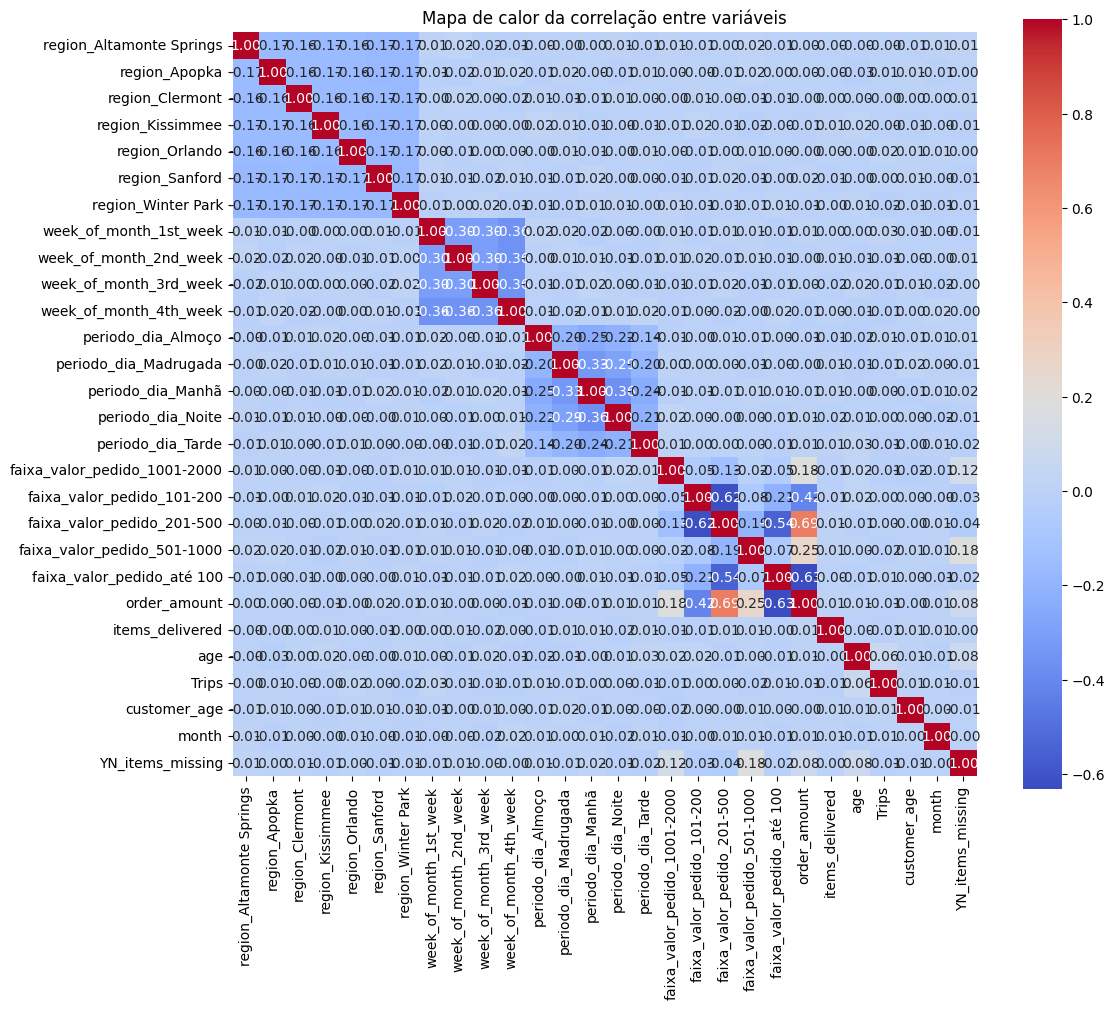

In [131]:
corr = df_encoded.corr(method='spearman')

plt.figure(figsize=(12, 10))  # ajustar o tamanho da figura
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Mapa de calor da correlação entre variáveis')
plt.show()


In [132]:
corr['YN_items_missing'].sort_values(ascending=True)

faixa_valor_pedido_201-500     -0.043783
faixa_valor_pedido_101-200     -0.032918
periodo_dia_Tarde              -0.020467
faixa_valor_pedido_até 100     -0.015046
region_Sanford                 -0.013030
Trips                          -0.008868
periodo_dia_Noite              -0.007751
region_Kissimmee               -0.007563
week_of_month_1st_week         -0.007261
region_Winter Park             -0.006334
periodo_dia_Madrugada          -0.005639
customer_age                   -0.005289
month                          -0.004924
week_of_month_4th_week         -0.000886
week_of_month_3rd_week         -0.000077
items_delivered                 0.001202
region_Orlando                  0.001266
region_Apopka                   0.003539
week_of_month_2nd_week          0.008285
region_Clermont                 0.009016
region_Altamonte Springs        0.013460
periodo_dia_Almoço              0.014866
periodo_dia_Manhã               0.016313
order_amount                    0.078103
age             

In [133]:
# # Separa as classes
# df_majority = df_encoded[df_encoded['YN_items_missing'] == 0]
# df_minority = df_encoded[df_encoded['YN_items_missing'] == 1]

# # Oversample a minoria
# df_minority_oversampled = df_minority.sample(n=int(len(df_majority)*0.5), replace=True, random_state=42)

# # Junta os dados balanceados
# df_balanced = pd.concat([df_majority, df_minority_oversampled])

# # Embaralha o dataset
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# X = df_balanced.drop(columns=['YN_items_missing'])  # substitua pelo nome da sua coluna target
# y = df_balanced['YN_items_missing']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

### Outros modelos

In [134]:
# # Lista de modelos
# modelos = {
#     "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
#     "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
#     "XGBoost": XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "KNN": KNeighborsClassifier(n_neighbors=5)
# }

# for nome, modelo in modelos.items():
#     print(f"\n----- {nome} -----")
#     # Treina com os dados balanceados
#     modelo.fit(X_train, y_train)

#     # Prediz com os dados de teste (desbalanceado)
#     y_pred = modelo.predict(X_test)

#     # Métricas
#     acc = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
#     recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

#     print("Acurácia:", acc)
#     print("Precision:", precision)
#     print("Recall:", recall)
#     print("Relatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0))


In [135]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# # Lista de modelos com bons resultados em desequilíbrio
# modelos = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
#     "SVM (Linear)": SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
#     "Naive Bayes": GaussianNB(),
#     "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
# }

# # Treinamento e avaliação
# for nome, modelo in modelos.items():
#     print(f"\n----- {nome} -----")

#     # Cria pipeline completo com pré-processamento + modelo
#     # Aplica escalonamento apenas se necessário (para todos, é seguro manter)
#     pipeline = Pipeline([
#         ("escalonamento", StandardScaler()),
#         ("classificador", modelo)
#     ])

#     # Treina o modelo com X_train e y_train (já separados antes)
#     pipeline.fit(X_train, y_train)

#     # Faz as previsões
#     y_pred = pipeline.predict(X_test)

#     # Métricas
#     acc = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
#     recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

#     print("Acurácia:", acc)
#     print("Precision:", precision)
#     print("Recall:", recall)
#     print("Relatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0))


In [136]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

# # Lista de modelos
# modelos = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
#     "SVM (Linear)": SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
#     "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42),
#     "CatBoost": CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42)
# }

# # Loop de treino e avaliação
# for nome, modelo in modelos.items():
#     print(f"\n----- {nome} -----")

#     # Alguns modelos precisam de escalonamento, outros não — pipeline funciona para todos
#     pipeline = Pipeline([
#         ("escalonamento", StandardScaler()),
#         ("classificador", modelo)
#     ])

#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)

#     # Métricas
#     acc = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
#     recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

#     print("Acurácia:", acc)
#     print("Precision:", precision)
#     print("Recall:", recall)
#     print("Relatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0))


Pegando 100% dos dados

🔍 Buscando melhores parâmetros para: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2760, number of negative: 6757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 9517, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Melhores parâmetros: {'clf__learning_rate': 0.1, 'clf__max_d

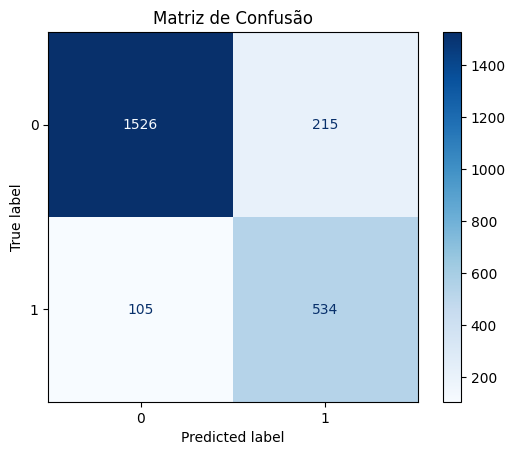

In [ ]:
# Separa as classes
df_majority = df_encoded[df_encoded['YN_items_missing'] == 0]
df_minority = df_encoded[df_encoded['YN_items_missing'] == 1]

# Oversample a minoria
df_minority_oversampled = df_minority.sample(n=int(len(df_majority)*0.4), replace=True, random_state=42)

# Junta os dados balanceados
df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Embaralha o dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced.drop(columns=['YN_items_missing'])  # substitua pelo nome da sua coluna target
y = df_balanced['YN_items_missing']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Dicionário com modelos e grids
modelos_grids = {
    "LightGBM": {
        "pipeline": Pipeline([
            ("clf", LGBMClassifier(class_weight='balanced', random_state=42))
        ]),
        "params": {
            "clf__learning_rate": [0.01, 0.1],
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [4, 6, 8],
        }
    }
}

# Loop para treinar e avaliar cada modelo
for nome, estrutura in modelos_grids.items():
    print(f"\n🔍 Buscando melhores parâmetros para: {nome}")
    
    grid_search = GridSearchCV(
        estimator=estrutura["pipeline"],
        param_grid=estrutura["params"],
        scoring='recall',  # ou 'f1', 'roc_auc'
        cv=5,
        n_jobs=-1
    )

    # Treinamento no conjunto balanceado
    grid_search.fit(X_train, y_train)

    # Melhor modelo encontrado
    best_model = grid_search.best_estimator_
    print("Melhores parâmetros:", grid_search.best_params_)

    # Avaliação no conjunto de teste original
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

    print("Acurácia:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Relatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0))
    # 1. Gerar a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz:", cm)
    # 2. Exibir a matriz de confusão de forma visual
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.show()


Melhor modelo até o momento é o **LightGBM**